### Visualizing TFIDF Model of the June 26 1960 Arab Observer

This notebook contains the required code to make visualizations to analyze TFIDF models of the Arab Observer

In [1]:
import pandas as pd
import altair as alt
alt.renderers.enable('notebook')
alt.data_transformers.enable('default', max_rows=None)
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import ast

In [132]:
# Read in required datasets
# Full Corpus
full_corpus_df = pd.read_json('./data/arab_observer_corpus_cleaned.json', orient='records')

full_corpus_url = './data/arab_observer_corpus_cleaned.json'

Function for comparing TFIDF models

In [104]:
def normalize_texts(original_df):
    original_df_texts = ' '.join(original_df.cleaned_spacy_text)
    original_df_texts = original_df_texts.split(' ')
    val = round(len(original_df_texts) / len(original_df))
    text = []
    for i in range(0, len(original_df_texts), val):
        chunk = ' '.join(original_df_texts[i:i + val])
#         print(chunk)
        if i + val + val > len(original_df_texts):
            chunk = ' '.join(original_df_texts[i:])
            text.append(chunk)
            break
        text.append(chunk)
    split_original_df = pd.DataFrame({'cleaned_spacy_text': text})
#     print(split_original_df)
    split_original_df['token_counts'] = split_original_df.cleaned_spacy_text.str.split().str.len()
    split_original_df['doc'] = split_original_df.index
    return split_original_df

In [97]:
def create_tfidf_model(df, ngr, model_identifier, max_terms, maxdf=1.0):
    
    vectorizer = TfidfVectorizer(ngram_range=ngr, max_df=maxdf)
    docs = vectorizer.fit_transform(df.cleaned_spacy_text.tolist())
    features = vectorizer.get_feature_names()
    count = np.squeeze(np.asarray(docs.sum(axis=0)))
    sorted_count = count.argsort()[::-1]
    dist_df =pd.DataFrame({'freq': count, 'term':np.array(features)})
    dist_df['type'] = model_identifier
    dist_df['freqz'] = dist_df[['freq']].apply(lambda x: (x-x.min())/(x.max()-x.min())+ 0.000001)
    dist_df.sort_values(by=['freqz'], inplace=True, ascending=False)
    df2 = pd.DataFrame(docs.toarray(), columns = features)
    df3 = df2.T
    df3['term'] = df3.index
    df3.reset_index(inplace=True, drop=True)
    df_melted = df3.melt('term', value_name='value', var_name='doc')

    df_merged = dist_df.merge(df_melted, on='term', how='inner')
    df_terms = df_merged.copy()
    df_terms = df_terms.drop_duplicates('term')
    
    return df_terms[0:max_terms]

In [88]:
def get_distribution(df, field_x, field_y):
    chart = alt.Chart(df).mark_bar().encode(
        y=alt.Y(field_y+':O',
                sort=alt.EncodingSortField(
                field=field_x,  # The field to use for the sort
                op="sum",  # The operation to run on the field prior to sorting
                order="descending"  # The order to sort in
            )
        ),
        x=field_x+':Q'
    ).properties(
        height=250
    )
    return chart

In [ ]:
df_terms = {
    'first_df_type': 'early corpus',
    'second_df_type': 'late corpus',
    'third_df_type': 'common both corpuses'
}

First visualization of TF-IDF model for June 26th, 1960 issue of Arab Observer compared to normalized version

In [89]:
df_june = full_corpus_df.loc[full_corpus_df.date.str.contains('1960-June')]
#Turn data into json
df_june_url = './data/arab_observer_corpus_cleaned_june1960.json'
df_june.to_json(df_june_url, orient='records')

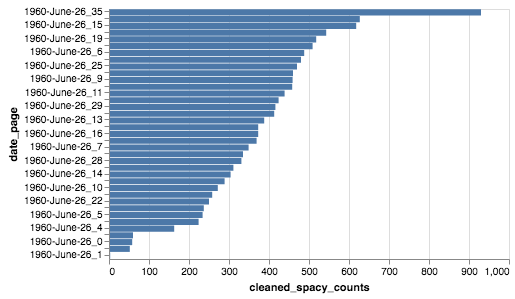

In [90]:
chart_june = get_distribution(df_june, 'cleaned_spacy_counts', 'date_page')
chart_june

In [114]:
tfidf_june = create_tfidf_model(df_june, (1,2), 'june_original_issue', 50)

terms = tfidf_june.term.tolist()
frames = []
for t in terms:
    rows = df_june.loc[df_june.cleaned_spacy_text.str.contains(t) == True].copy()
    rows['counts'] = rows.cleaned_spacy_text.str.count(t)
    rows['term'] = t
    rows = rows[['date', 'page_number', 'counts', 'term']]
    frames.append(rows)
df_june_counts = pd.concat(frames, ignore_index=True)

#Turn data into json
tfidf_june_url = './data/arab_observer_corpus_cleaned_tfidf_june1960.json'
tfidf_june.to_json(tfidf_june_url, orient='records')
df_june_counts_url = './data/arab_observer_corpus_cleaned_counts_june1960.json'
df_june_counts.to_json(df_june_counts_url, orient='records')

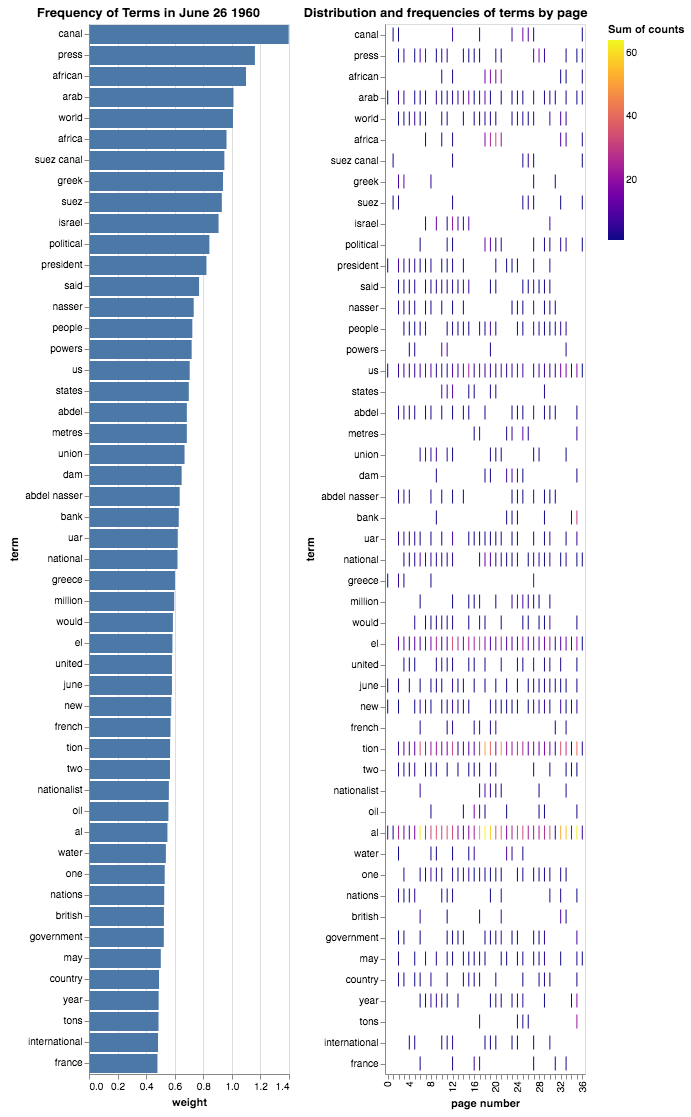

In [115]:

alt.data_transformers.enable('json')
alt.themes.enable('opaque')
total_freq = alt.Chart(tfidf_june_url).mark_bar().encode(
    x=alt.X('sum(freq):Q', axis=alt.Axis(title='weight')),
    y=alt.Y(
        'term:N',
         sort=terms
    ),

).properties(
    width=200,
    title='Frequency of Terms in June 26 1960'
)

page_freq = alt.Chart(df_june_counts_url).mark_tick().encode(
    x=alt.X('page_number:O', axis=alt.Axis(title='page number')),
    y=alt.Y(
        'term:N',
         sort=terms
    ),
    color=alt.Color('sum(counts):Q', scale=alt.Scale(scheme='plasma')),

).properties(
    width=200, title='Distribution and frequencies of terms by page'
)



charts = alt.hconcat(total_freq | page_freq )
charts

In [106]:
norm_june = normalize_texts(df_june)
norm_june_url = './data/arab_observer_corpus_cleaned_june1960_norm.json'
norm_june.to_json(norm_june_url, orient='records')
chart_norm_june = get_distribution(norm_june_url, 'token_counts', 'doc')

In [117]:
tfidf_normjune = create_tfidf_model(norm_june, (1,2), 'june_norm_issue', 50)

terms = tfidf_normjune.term.tolist()
frames = []
for t in terms:
    rows = norm_june.loc[norm_june.cleaned_spacy_text.str.contains(t) == True].copy()
    rows['counts'] = rows.cleaned_spacy_text.str.count(t)
    rows['term'] = t
    rows = rows[['doc', 'counts', 'term']]
    frames.append(rows)
norm_june_counts = pd.concat(frames, ignore_index=True)

#Turn data into json
tfidf_normjune_url = './data/arab_observer_corpus_cleaned_tfidf_june1960_norm.json'
tfidf_normjune.to_json(tfidf_normjune_url, orient='records')
norm_june_counts_url = './data/arab_observer_corpus_cleaned_counts_june1960_norm.json'
norm_june_counts.to_json(norm_june_counts_url, orient='records')

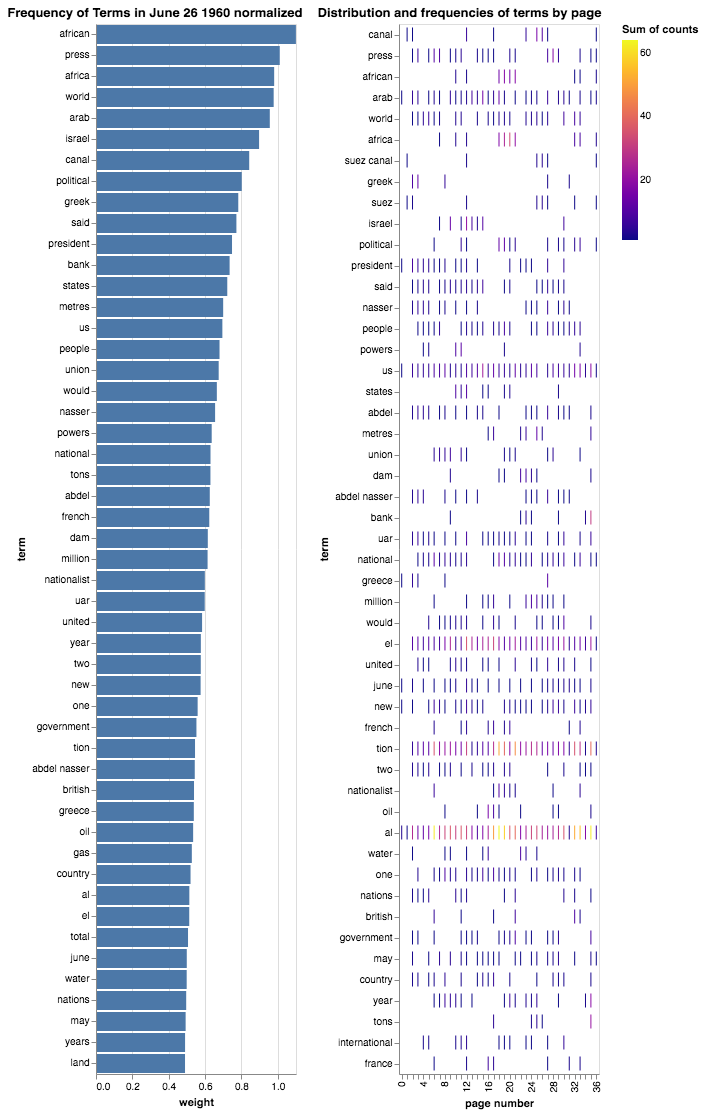

In [118]:


alt.themes.enable('opaque')
total_freq = alt.Chart(tfidf_normjune_url).mark_bar().encode(
    x=alt.X('sum(freq):Q', axis=alt.Axis(title='weight')),
    y=alt.Y(
        'term:N',
         sort=terms
    ),

).properties(
    width=200,
    title='Frequency of Terms in June 26 1960 normalized'
)

page_freq2 = alt.Chart(norm_june_counts_url).mark_tick().encode(
    x=alt.X('doc:O', axis=alt.Axis(title='page number')),
    y=alt.Y(
        'term:N',
         sort=terms
    ),
    color=alt.Color('sum(counts):Q', scale=alt.Scale(scheme='plasma')),

).properties(
    width=200, title='Distribution and frequencies of terms by page'
)


charts = alt.hconcat(total_freq | page_freq )
charts